<a href="https://colab.research.google.com/github/chloepalin/chloepalin.github.io/blob/master/RealOrFake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
!ls gdrive/MyDrive


 animal_classifier.zip
'CHLOE PERSONAL USB'
 ciimages.zip
'Colab Notebooks'
 CSSE3010
'Design and Development of an Assistive Technology Device for Enhancing the Running Performance of Blind Athletes.gdoc'
'Design and Development of an Assistive Technology Device for Enhancing the Running Performance of Blind Athleteshesis.gdoc'
'dino code.gdoc'
'EA competencies.gdoc'
 ENGG4900
'Engineering reflections.gdoc'
'FIRST YEAR'
'gui for ELEC4630 a2.3.gdoc'
 HBI
 HOUSE
'How to become a chartered engineer.gdoc'
'LAB4 BIOE6403.gdoc'
'Market Analysis and sales forecast..gdoc'
 milestone.pdf
 ProgressSem1.pptx
'Project brief for my thesis.gdoc'
'Proposal Draft.gdoc'
 RANDOM
'SECOND YEAR'
'sem participation.pdf'
 thesis
'Thesis Idea Development.gdoc'
'THIRD YEAR'
'Untitled document (1).gdoc'
'Untitled document (2).gdoc'
'Untitled document (3).gdoc'
'Untitled document (4).gdoc'
'Untitled document (5).gdoc'
'Untitled document (6).gdoc'
'Untitled document.gdoc'
 workdiagramss4.pdf


In [20]:
import os
import random
import shutil

TRAIN_DATA_DIRECTORY = '/content/train'
TRAIN_REAL_DIRECTORY = '/content/train/REAL'
TRAIN_FAKE_DIRECTORY = '/content/train/FAKE'

TEST_DATA_DIRECTORY = '/content/test'
TEST_REAL_DIRECTORY = '/content/test/REAL'
TEST_FAKE_DIRECTORY = '/content/test/FAKE'



In [21]:
import tensorflow as tf

img_height = 32 # The dataset is all 32px but this is here just to make sure
img_width = 32
batch_size = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DATA_DIRECTORY,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DATA_DIRECTORY,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Quick sanity check to make sure it's all loaded properly
print("Test:")
class_names = train_ds.class_names
print(class_names)

print("Train:")
class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Test:
['FAKE', 'REAL']
Train:
['FAKE', 'REAL']


In [22]:
import tensorflow as tf

# Resize the images
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

# Apply data augmentation to training data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Configure the dataset for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [23]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/3
3125/3125 [==============================] - 200s 60ms/step - loss: 0.4887 - accuracy: 0.7600 - val_loss: 0.5267 - val_accuracy: 0.7613
Epoch 2/3
3125/3125 [==============================] - 159s 51ms/step - loss: 0.3964 - accuracy: 0.8192 - val_loss: 0.4234 - val_accuracy: 0.8081
Epoch 3/3
625/625 [==============================] - 8s 13ms/step - loss: 0.4046 - accuracy: 0.8301
Loss: 0.40464159846305847
Accuracy: 0.8300999999046326


Found 20000 files belonging to 2 classes.
625/625 [==============================] - 11s 18ms/step
Confusion Matrix:
[[6433 3567]
 [6381 3619]]


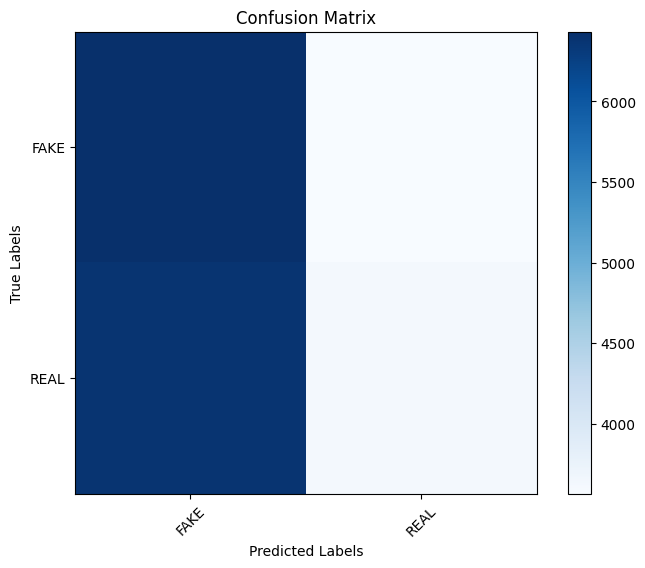

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DATA_DIRECTORY,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# Preprocess the test data
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Extract true labels from the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Make predictions on the test data
y_pred = model.predict(test_ds)
y_pred = np.squeeze(y_pred)  # Flatten the predictions

# Convert predictions to class labels
y_pred_labels = np.round(y_pred).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()

plt.show()
